In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from itertools import combinations
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages/')
import community
import networkx as nx

/home/lizard/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
diabetic_data = pd.read_csv('dataset_diabetes/diabetic_data.csv')

In [3]:
diag_codes = pd.read_csv('icd9.csv',names=['code','diag_description'])

In [4]:
diag_codes_dict = dict(zip(diag_codes['code'].values,diag_codes['diag_description'].values))

In [5]:
def get_description(diag):
    if diag in diag_codes_dict.keys():
        ret = diag_codes_dict[diag]
    else:
        ret = diag
    return ret

In [6]:
ids_mapping_dict = {}
key = ''
with open('dataset_diabetes/IDs_mapping.csv','r') as f:
    for line in  f.readlines():
        line =  line.strip()
        if line == ',':
            continue
        vals = line.split(',')
        if vals[1] == 'description':
            key = vals[0]
            ids_mapping_dict[key] = {}
            continue
        else:
            ids_mapping_dict[key][vals[0]]=  vals[1]

In [7]:
nominal_columns = [u'race', u'gender', u'age',
       u'admission_type_id', u'discharge_disposition_id',
       u'admission_source_id', u'payer_code',
       u'medical_specialty', u'diag_1', u'diag_2', u'diag_3',
       u'max_glu_serum', u'A1Cresult', u'change', u'diabetesMed', u'readmitted']

numeric_columns = [u'time_in_hospital',u'num_lab_procedures', u'num_procedures',
       u'num_medications', u'number_outpatient', u'number_emergency',
       u'number_inpatient','number_diagnoses']

medicaation_columns = [u'metformin',u'repaglinide', u'nateglinide', u'chlorpropamide', u'glimepiride',
       u'acetohexamide', u'glipizide', u'glyburide', u'tolbutamide',
       u'pioglitazone', u'rosiglitazone', u'acarbose', u'miglitol',
       u'troglitazone', u'tolazamide', u'examide', u'citoglipton', u'insulin',
       u'glyburide-metformin', u'glipizide-metformin',
       u'glimepiride-pioglitazone', u'metformin-rosiglitazone',
       u'metformin-pioglitazone']

cols_to_remove  = [u'encounter_id', u'patient_nbr',u'weight']

In [8]:
diabetic_data['admission_source_id'] = diabetic_data['admission_source_id'].apply(lambda x: ids_mapping_dict['admission_source_id'][str(x)])
diabetic_data['discharge_disposition_id'] = diabetic_data['discharge_disposition_id'].apply(lambda x: ids_mapping_dict['discharge_disposition_id'][str(x)])
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].apply(lambda x: ids_mapping_dict['admission_type_id'][str(x)])

In [9]:
diabetic_data['diag_1'] = diabetic_data['diag_1'].apply(get_description)
diabetic_data['diag_2'] = diabetic_data['diag_2'].apply(get_description)
diabetic_data['diag_3'] = diabetic_data['diag_3'].apply(get_description)

# Features Connection

In [248]:
arr = []
threshols = 5.0
samples_thres = 500
for comb in combinations(nominal_columns + numeric_columns,2):
    ct = pd.crosstab(diabetic_data[comb[0]],diabetic_data[comb[1]])
    ct = ct[ct>samples_thres].fillna(0).apply(lambda r: r/r.sum(), axis=1).apply(lambda r: r/r.sum(), axis=1)
    distribution = diabetic_data[comb[1]].value_counts(normalize=True)
    for col in ct.columns:
        ct[col]=  ct[col] / distribution[col]
    res = ct[(ct> threshols) | (ct <  (1.0/threshols))].dropna(how='all',axis=1).dropna(how='all',axis=0)
    if res.shape[0] > 0:
        col1 = res.index.name
        col2 = res.columns.name
        for row in res.iterrows():
            for idx,val in enumerate(row[1],0):
                if val > 0:
                    arr.append([col1,row[0],col2,row[1].keys()[idx],val])
                    #print "%s: %s and %s: %s are %.2f" % (col1,row[0],col2,row[1].keys()[idx],val)
    ct = pd.crosstab(diabetic_data[comb[1]],diabetic_data[comb[0]])
    ct = ct[ct>samples_thres].fillna(0).apply(lambda r: r/r.sum(), axis=1).apply(lambda r: r/r.sum(), axis=1)
    distribution = diabetic_data[comb[0]].value_counts(normalize=True)
    for col in ct.columns:
        ct[col]=  ct[col] / distribution[col]
    res = ct[(ct> threshols) | (ct <  (1.0/threshols))].dropna(how='all',axis=1).dropna(how='all',axis=0)
    if res.shape[0] > 0:
        col1 = res.index.name
        col2 = res.columns.name
        for row in res.iterrows():
            for idx,val in enumerate(row[1],0):
                if val > 0:
                    arr.append([col1,row[0],col2,row[1].keys()[idx],val])
                        #print "%s: %s and %s: %s are %.2f" % (col1,row[0],col2,row[1].keys()[idx],val)



In [249]:
res_df = pd.DataFrame(arr,columns = ['feature 1','value 1','feature 2','value 2','ratio'])

In [250]:
res_df.to_csv('res_all_encounters.csv',index=False)

In [10]:
diabetic_data['encounter_id'] = diabetic_data['encounter_id'].astype('int')

patient_first_encounter = diabetic_data[[u'encounter_id', u'patient_nbr']].groupby('patient_nbr').min()['encounter_id'].reset_index()

diabetic_data_first_encounter = diabetic_data.merge(patient_first_encounter,on=['patient_nbr','encounter_id'])

In [112]:
arr = []
threshols = 1.5
samples_thres = 100
for comb in combinations(nominal_columns + numeric_columns,2):
    ct = pd.crosstab(diabetic_data_first_encounter[comb[0]],diabetic_data_first_encounter[comb[1]])
    norm_ct = ct.fillna(0).apply(lambda r: r/r.sum(), axis=1).apply(lambda r: r/r.sum(), axis=1)
    norm_ct = norm_ct[ct>samples_thres].fillna(0)
    distribution = diabetic_data_first_encounter[comb[1]].value_counts(normalize=True)
    for col in norm_ct.columns:
        norm_ct[col] =  norm_ct[col] / distribution[col]
    res = norm_ct[(norm_ct> threshols) | (norm_ct <  (1.0/threshols))].dropna(how='all',axis=1).dropna(how='all',axis=0)
    if res.shape[0] > 0:
        col1 = res.index.name
        col2 = res.columns.name
        for row in res.iterrows():
            for idx,val in enumerate(row[1],0):
                if val > 0:
                    arr.append([col1,row[0],col2,row[1].keys()[idx],val,ct.loc[row[0],row[1].keys()[idx]]])

#                     #print "%s: %s and %s: %s are %.2f" % (col1,row[0],col2,row[1].keys()[idx],val)
#     ct = pd.crosstab(diabetic_data_first_encounter[comb[1]],diabetic_data_first_encounter[comb[0]])
#     norm_ct = ct.fillna(0).apply(lambda r: r/r.sum(), axis=1).apply(lambda r: r/r.sum(), axis=1)
#     norm_ct = norm_ct[ct>samples_thres].fillna(0)
#     distribution = diabetic_data_first_encounter[comb[0]].value_counts(normalize=True)
#     for col in norm_ct.columns:
#         norm_ct[col] =  norm_ct[col] / distribution[col]
#     res = norm_ct[(norm_ct> threshols) | (norm_ct <  (1.0/threshols))].dropna(how='all',axis=1).dropna(how='all',axis=0)
#     if res.shape[0] > 0:
#         col1 = res.index.name
#         col2 = res.columns.name
#         for row in res.iterrows():
#             for idx,val in enumerate(row[1],0):
#                 if val > 0:
#                     arr.append([col1,row[0],col2,row[1].keys()[idx],val,ct.loc[row[0],row[1].keys()[idx]]])

                        #print "%s: %s and %s: %s are %.2f" % (col1,row[0],col2,row[1].keys()[idx],val)


In [114]:
res_df = pd.DataFrame(arr,columns = ['feature 1','value 1','feature 2','value 2','ratio','num samples'])
res_df.to_csv('res_first_encounter.csv',index=False)

[0-10)
[10-20)
[20-30)
[30-40)
[40-50)
[50-60)
[60-70)
[70-80)
[80-90)
[90-100)


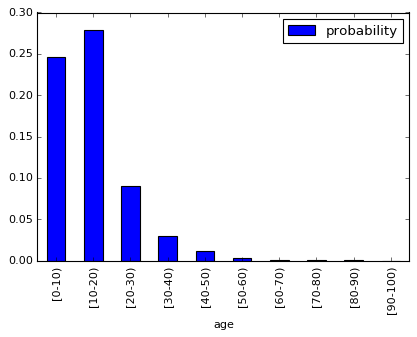

In [125]:
# ct.loc['AfricanAmerican','Hypertensive renal disease  ']

# norm_ct = ct.fillna(0).apply(lambda r: r/r.sum(), axis=1).apply(lambda r: r/r.sum(), axis=1)#.loc[:,'Hypertensive renal disease  ']

# norm_ct[ct>samples_thres].loc[:,'Hypertensive renal disease  ']

# ct[ct>samples_thres].loc[:,'Hypertensive renal disease  ']

# 124.0/323

# diabetic_data_first_encounter['race'].unique()

arr = []
for age in diabetic_data_first_encounter['age'].unique():
    print age
    try:
        val = diabetic_data_first_encounter[diabetic_data_first_encounter['age']==age]\
    ['diag_1'].value_counts(normalize=True)['250.13']
    except:
        val = 0
    arr.append([age,val])

plt_df = pd.DataFrame(arr,columns=['age','probability'])

plt_df.set_index('age').plot(kind='bar')

# diabetic_data_first_encounter['diag_1'].value_counts(normalize=True)['Hypertensive renal disease  ']

# diabetic_data_first_encounter[diabetic_data_first_encounter['race']=='Hispanic']\
# ['diag_1'].value_counts(normalize=True)['Hypertensive renal disease  ']

In [122]:
dict(diabetic_data_first_encounter[diabetic_data_first_encounter['age']==age]\
['diag_1'].value_counts(normalize=True)).keys()

['Other bacterial pneumonia  ',
 'Other congenital anomalies of digestive',
 'Diabetes mellitus   ',
 'Other disorders of urethra and',
 'Acute appendicitis   ',
 'Epilepsy    ',
 'Disorders of fluid',
 'Pneumonia due to other specified',
 '250.03',
 '250.02',
 '250.01',
 '250.83',
 '250.81',
 '79',
 'General symptoms   ',
 'Other symptoms involving abdomen and',
 'Pneumonia',
 'Acute bronchitis and bronchiolitis ',
 'Symptoms involving respiratory system and',
 'V58',
 '250.33',
 '250.31',
 'Viral pneumonia   ',
 '250.11',
 '250.12',
 '250.13',
 'Asthma    ',
 'Other cellulitis and abscess ',
 '250.93',
 'Gastritis and duodenitis  ']

In [286]:
# patient_num_encounters = diabetic_data[[u'encounter_id', u'patient_nbr']].groupby('patient_nbr').size().reset_index()

# diabetic_data_num_encounters = diabetic_data.merge(patient_num_encounters,on=['patient_nbr'])

In [287]:
#diabetic_data_num_encounters[diabetic_data_num_encounters[0]>2]['change'].value_counts(normalize=True)

In [288]:
#diabetic_data_num_encounters['change'].value_counts(normalize=True)

# Clustering

In [332]:
# patient_features  = [u'race', u'gender', u'age',u'admission_type_id',u'admission_source_id',\
#                      u'payer_code',u'number_outpatient', u'number_emergency',u'number_inpatient']
patient_features  = [u'race', u'gender', u'age',u'admission_type_id',u'admission_source_id',\
                      u'payer_code']

In [333]:
patient_df = diabetic_data_first_encounter[patient_features]

def get_age(age_group):
    return np.mean([int(x) for x in age_group.replace('[','').replace(')','').split('-')])

patient_df['age'] = patient_df['age'].apply(get_age)

/home/lizard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [334]:
#cols_to_normalize = ['age','number_outpatient','number_emergency','number_inpatient']
cols_to_normalize = ['age']
for col in cols_to_normalize:
    patient_df[col] = (patient_df[col] - patient_df[col].min()) / (patient_df[col].max() - patient_df[col].min())

/home/lizard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [335]:
cols_to_one_hot = [u'race', u'gender',u'admission_type_id',u'admission_source_id',u'payer_code']

In [336]:
dummy_df = pd.get_dummies(patient_df[cols_to_one_hot])

In [337]:
patient_df = pd.concat([patient_df,dummy_df],axis=1)

In [338]:
for col in cols_to_one_hot:
    del patient_df[col]

In [339]:
gc.collect()

168

In [346]:
#Find best k
res = []
k = 40
kmeans = KMeans(n_clusters=k,random_state=0,n_jobs=3).fit(patient_df)
patient_df['cluster'] = kmeans.labels_
del kmeans
sample = patient_df.sample(5000)
score = metrics.silhouette_score(sample.iloc[:,:-1],sample.iloc[:,-1])
print k,score
res.append(score)
gc.collect()

40 0.408269971129


90

In [460]:
metrics.silhouette_score?

In [461]:
best_k = 8
kmeans = KMeans(n_clusters=best_k,random_state=0,n_jobs=3).fit(patient_df)

In [462]:
patient_df['cluster'] = kmeans.labels_

In [423]:
mean = patient_df.iloc[:,:-1].mean(axis=1)
std = patient_df.iloc[:,:-1].std(axis=1)
res = pd.DataFrame(zip(mean,std,kmeans.labels_) )

In [463]:
diabetic_data_first_encounter['cluster'] = kmeans.labels_

In [472]:
diabetic_data_first_encounter[diabetic_data_first_encounter['cluster']==6]['age'].value_counts(normalize=True)

[70-80)     0.267825
[80-90)     0.225884
[60-70)     0.192431
[50-60)     0.137807
[40-50)     0.077192
[90-100)    0.047334
[30-40)     0.032554
[20-30)     0.011784
[10-20)     0.006291
[0-10)      0.000899
Name: age, dtype: float64

In [401]:
from sklearn.decomposition import PCA

In [451]:
reduced_data = PCA(n_components=2).fit_transform(kmeans.cluster_centers_)

In [452]:
pca_df = pd.DataFrame(reduced_data)

In [453]:
pca_df.shape

(40, 2)

In [454]:
samp= pca_df.values

In [449]:
samp = pca_df[(pca_df['cluster'] == 0)].sample(200).values

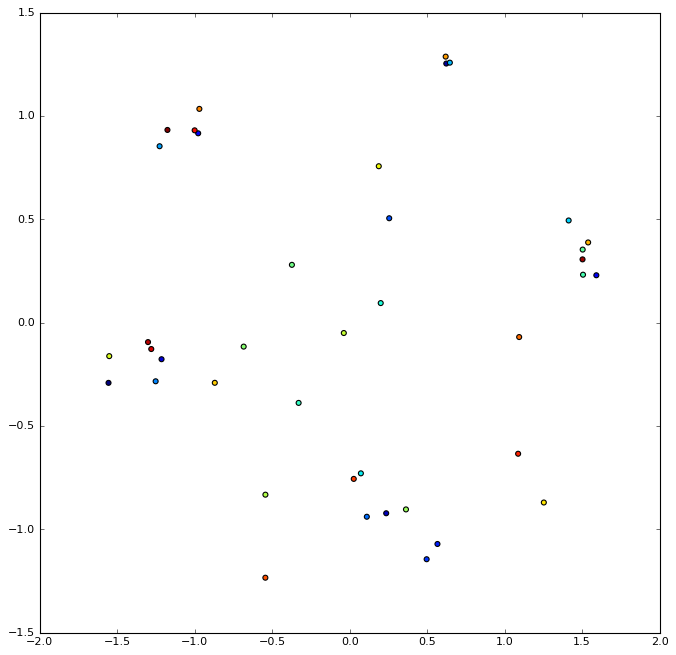

In [458]:
plt.figure(figsize = (10,10))
plt.scatter(samp[:, 0], samp[:, 1],c = range(40))

In [353]:
for i in range(40):
    print diabetic_data_first_encounter[diabetic_data_first_encounter['cluster']==i].shape[0]

3456
1754
5943
1552
1683
2622
1896
1753
3972
2511
2559
1628
5194
4337
756
1043
1458
1365
1357
851
1789
1049
1760
1226
997
1068
507
901
2084
1577
661
585
2072
742
436
740
1914
1478
1462
780


In [68]:
patient_df = diabetic_data_first_encounter[patient_features]

In [59]:
race_dict = dict(zip(patient_df['race'].unique(),range(patient_df['race'].nunique())))
gender_dict = dict(zip(patient_df['gender'].unique(),range(patient_df['gender'].nunique())))
payer_code_dict = dict(zip(patient_df['payer_code'].unique(),range(patient_df['payer_code'].nunique())))

In [10]:
race_dict

{'?': 2,
 'AfricanAmerican': 1,
 'Asian': 4,
 'Caucasian': 0,
 'Hispanic': 5,
 'Other': 3}

In [61]:
patient_df['race'] = patient_df['race'].apply(lambda x :race_dict[x])
patient_df['gender'] = patient_df['gender'].apply(lambda x :gender_dict[x])
patient_df['payer_code'] = patient_df['payer_code'].apply(lambda x :payer_code_dict[x])

/home/lizard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [16]:
from scipy.spatial import distance

In [27]:
patient_df.sample()

,race,gender,age,admission_type_id,admission_source_id,payer_code,number_outpatient,number_emergency,number_inpatient
57959,0,1,95,1,7,MC,2,0,0


In [36]:
cols_to_normalize = ['age','number_outpatient','number_emergency','number_inpatient']
for col in cols_to_normalize:
    patient_df[col] = (patient_df[col] - patient_df[col].min()) / (patient_df[col].max() - patient_df[col].min())

/home/lizard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [46]:
nominal_indices = [0,1,3,4,5]
numeric_indices = [2,6,7,8]

In [173]:
nominal_coefficient = []
for i in range(6):
    nominal_coefficient.append({})
for idx in nominal_indices:
    nominal_coefficient[idx] = dict(1 / patient_df.iloc[:,idx].value_counts(normalize=True))

In [195]:
def get_similarity(x_1,x_2):
    sim = np.zeros(9)
    sim[nominal_indices] =  [int(x) for x in x_1[nominal_indices] == x_2[nominal_indices]]
    for idx in nominal_indices:
        sim[idx] = sim[idx] * nominal_coefficient[idx][int(x_1[idx])]
    sim[numeric_indices] = 1 - np.abs(x_1[numeric_indices] - x_2[numeric_indices])   
    return np.mean(sim)

In [202]:
sample_df = patient_df.sample(10000)

In [203]:
vals = sample_df.values

In [204]:
import datetime
print datetime.datetime.now()
dist = distance.cdist(vals, vals, get_similarity)
print datetime.datetime.now()

2019-04-29 23:09:28.017828
2019-04-30 00:40:11.909522


In [207]:
import pickle
with open ('dist.pkl','wb') as f:
    pickle.dump(dist,f)

In [215]:
sample_df.to_csv('sample.csv')

In [219]:
diabetic_data_first_encounter.to_csv('diabetic_data_first_encounter.csv')

In [221]:
patient_df.to_csv('patient_df.csv')

In [220]:
patient_df.shape

(71518, 9)

In [475]:
dist[0][10]

0.9565763353412825

In [218]:
diabetic_data_first_encounter.iloc[sample_df.head(2).index,:]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
30393,124285368,41430330,Caucasian,Male,[70-80),?,1,3,7,13,...,No,Steady,No,No,No,No,No,No,Yes,>30
26838,109803996,23666013,Caucasian,Male,[70-80),?,1,6,7,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [222]:
dist[5][1:].argmax()

4

In [208]:
gc.collect()

55

In [476]:
type(dist)

numpy.ndarray

In [ ]:
G=nx.from_numpy_matrix(dist)

In [48]:
patient_features

[u'race',
 u'gender',
 u'age',
 u'admission_type_id',
 u'admission_source_id',
 u'payer_code',
 u'number_outpatient',
 u'number_emergency',
 u'number_inpatient']

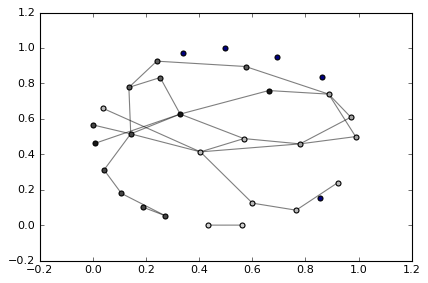

In [44]:

#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure
G = nx.erdos_renyi_graph(30, 0.05)

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [45]:
partition

{0: 0,
 1: 1,
 2: 2,
 3: 2,
 4: 3,
 5: 0,
 6: 4,
 7: 5,
 8: 2,
 9: 3,
 10: 3,
 11: 6,
 12: 3,
 13: 7,
 14: 2,
 15: 7,
 16: 6,
 17: 8,
 18: 7,
 19: 7,
 20: 8,
 21: 7,
 22: 0,
 23: 6,
 24: 7,
 25: 9,
 26: 6,
 27: 2,
 28: 10,
 29: 2}

In [37]:
# diabetic_data_first_encounter[diabetic_data_first_encounter['cluster']==i]['discharge_disposition_id']\
# .value_counts(normalize=True)

In [38]:
#diabetic_data_first_encounter['diabetesMed'].value_counts(normalize=True)

In [39]:
# for i in range(150):
#     try:
#         if diabetic_data_first_encounter[diabetic_data_first_encounter['cluster']==i]['diabetesMed']\
#     .value_counts(normalize=True)['Yes'] > 0.85:
#             print i
#     except:
#         pass

In [40]:
#del patient_df['cluster']

In [41]:
#clustering = DBSCAN(eps=3, min_samples=2).fit(patient_df)

In [104]:
# ct = pd.crosstab(diabetic_data['race'],diabetic_data['age']).apply(lambda r: r/r.sum(), axis=1)

# for i in range(1,5):
#     ax = ct.iloc[i,].plot(label=ct.index[i],figsize=(10,5))
#     ax.legend(loc='upper left')
# plt.show()

In [ ]:
# ct = pd.crosstab(diabetic_data['gender'],diabetic_data['age']).apply(lambda r: r/r.sum(), axis=1)

# for i in range(3):
#     ax = ct.iloc[i,].plot(label=ct.index[i],figsize=(10,5))
#     ax.legend(loc='upper left')
# plt.show()

In [ ]:
# ct = pd.crosstab(diabetic_data['race'],diabetic_data['gender']).apply(lambda r: r/r.sum(), axis=1)

# for i in range(1,5):
#     ax = ct.iloc[i,].plot(label=ct.index[i],figsize=(10,5))
#     ax.legend(loc='upper left')
# plt.show()

In [229]:
diabetic_data[numeric_columns].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
time_in_hospital,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186
num_lab_procedures,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773
num_procedures,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734
num_medications,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526
number_outpatient,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152
number_emergency,-0.009681,-0.002279,-0.038179,0.013180,0.091459,1.000000,0.266559,0.055539
number_inpatient,0.073623,0.039231,-0.066236,0.064194,0.107338,0.266559,1.000000,0.104710
number_diagnoses,0.220186,0.152773,0.073734,0.261526,0.094152,0.055539,0.104710,1.000000


In [232]:
diabetic_data_first_encounter[numeric_columns].corr().to_csv('corr.csv')

In [30]:
diabetic_data['num_procedures'].value_counts()

0    46652
1    20742
2    12717
3     9443
6     4954
4     4180
5     3078
Name: num_procedures, dtype: int64

In [26]:
for col in cols:
    print col,diabetic_data[col].nunique()

encounter_id 101766
patient_nbr 71518
race 6
gender 3
age 10
weight 10
admission_type_id 8
discharge_disposition_id 26
admission_source_id 17
time_in_hospital 14
payer_code 18
medical_specialty 73
num_lab_procedures 118
num_procedures 7
num_medications 75
number_outpatient 39
number_emergency 33
number_inpatient 21
diag_1 717
diag_2 749
diag_3 790
number_diagnoses 16
max_glu_serum 4
A1Cresult 4
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 2
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 4
miglitol 4
troglitazone 2
tolazamide 3
examide 1
citoglipton 1
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 2
metformin-rosiglitazone 2
metformin-pioglitazone 2
change 2
diabetesMed 2
readmitted 3


In [14]:
diabetic_data[diabetic_data[u'patient_nbr']==88785891].sample(1)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
74876,223647786,88785891,Caucasian,Female,[20-30),?,2,1,7,2,...,No,Down,No,No,No,No,No,Ch,Yes,<30


In [20]:
diabetic_data['num_medications'].value_counts()

13    6086
12    6004
11    5795
15    5792
14    5707
16    5430
10    5346
17    4919
9     4913
18    4523
8     4353
19    4078
20    3691
7     3484
21    3230
22    2868
6     2699
23    2426
24    2109
5     2017
25    1888
26    1608
27    1432
4     1417
28    1233
29    1000
3      900
30     849
31     712
32     623
      ... 
45      88
47      74
49      61
48      60
50      55
52      54
51      43
53      40
56      37
54      33
55      32
57      26
58      25
60      23
59      20
62      15
63      14
61      14
65      12
64       8
68       7
67       7
69       5
66       5
72       3
70       2
75       2
74       1
79       1
81       1
Name: num_medications, dtype: int64